# Usage

Uses https://github.com/beyond-all-reason/stacktrace_translator


0. Get infologs from https://server4.beyondallreason.info/telemetry/infolog/search by setting Errorcode to `spring.exe`
1. Download infologs into folder 'workdir'
2. Run code

In [1]:
import xmlrpc.client

In [5]:
# !wget https://server4.beyondallreason.info/telemetry/infolog/download/245615

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:

# URL of the XML-RPC server
server_url = "http://176.57.150.243:8000/"

# Connect to the server
server = xmlrpc.client.ServerProxy(server_url)

# Define a large string as input for the `translate_stacktrace` method
large_string = open("infolog_245615.log").read()

try:
    # Make the XML-RPC call to translate the stacktrace
    result = server.translate_stacktrace(large_string)
    print("Translation Result:", result)
except Exception as e:
    print("An error occurred:", e)

Translation Result: [['C:\\Users\\Loeloe\\AppData\\Local\\Programs\\Beyond-All-Reason\\data\\engine\\105.1.1-2511-g747f18b bar\\spring.exe', '0x14080a66f', '/spring/tools/pr-downloader/src/lib/base64/base64.cpp', 51], ['C:\\Users\\Loeloe\\AppData\\Local\\Programs\\Beyond-All-Reason\\data\\engine\\105.1.1-2511-g747f18b bar\\spring.exe', '0x14066cd81', '/spring/rts/System/LoadSave/DemoRecorder.cpp', 109], ['C:\\Users\\Loeloe\\AppData\\Local\\Programs\\Beyond-All-Reason\\data\\engine\\105.1.1-2511-g747f18b bar\\spring.exe', '0x1400857d8', '/spring/rts/Game/PreGame.cpp', 620], ['C:\\Users\\Loeloe\\AppData\\Local\\Programs\\Beyond-All-Reason\\data\\engine\\105.1.1-2511-g747f18b bar\\spring.exe', '0x140086339', '/mxe/usr/lib/gcc/x86_64-w64-mingw32.static/13.2.0/include/c++/bits/shared_ptr_base.h', 1070], ['C:\\Users\\Loeloe\\AppData\\Local\\Programs\\Beyond-All-Reason\\data\\engine\\105.1.1-2511-g747f18b bar\\spring.exe', '0x14008698c', '/spring/rts/Game/PreGame.cpp', 213], ['C:\\Users\\Loel

In [3]:
import os

In [5]:
workdir = "./infologs_2570/"
results = {}
for filename in os.listdir(workdir):
    try:
        contents = open(workdir+filename).read()
        result = server.translate_stacktrace(contents)
        print("Translation Result:", result)
        results[filename] = result
    except Exception as e:
        print("An error occurred:", e)



Translation Result: [['C:\\Users\\Archie Hitchings\\AppData\\Local\\Programs\\Beyond-All-Reason\\data\\engine\\105.1.1-2570-g0889e95 bar\\spring.exe', '0x140a1b0fd', '/spring/rts/Sim/Misc/YardmapStatusEffectsMap.h', 43], ['C:\\Users\\Archie Hitchings\\AppData\\Local\\Programs\\Beyond-All-Reason\\data\\engine\\105.1.1-2570-g0889e95 bar\\spring.exe', '0x140a139d1', '/spring/rts/Sim/MoveTypes/MoveDefHandler.cpp', 698], ['C:\\Users\\Archie Hitchings\\AppData\\Local\\Programs\\Beyond-All-Reason\\data\\engine\\105.1.1-2570-g0889e95 bar\\spring.exe', '0x1409ff9e1', '/spring/rts/Sim/MoveTypes/GroundMoveType.cpp', 3340], ['C:\\Users\\Archie Hitchings\\AppData\\Local\\Programs\\Beyond-All-Reason\\data\\engine\\105.1.1-2570-g0889e95 bar\\spring.exe', '0x140a08533', '/spring/rts/Sim/MoveTypes/GroundMoveType.cpp', 3352], ['C:\\Users\\Archie Hitchings\\AppData\\Local\\Programs\\Beyond-All-Reason\\data\\engine\\105.1.1-2570-g0889e95 bar\\spring.exe', '0x140a08d1a', '/spring/rts/System/float3.h', 342]

In [6]:
outf = open("translated_traces.tsv", 'w')
for fname, result in results.items():
    outf.write(fname + '\t' + str(result) + '\n')
outf.close()

In [7]:
class Node:
    def __init__(self,traceline):
        self.exename = traceline[0]
        self.address = traceline[1]
        self.codefile = traceline[2]
        self.codeline = traceline[3]
        self.children = []
        self.count = 0
    
class Edge:
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.weight = 1

In [8]:
trim_prefixes = [
    '/spring/rts/',
    '/mxe/usr/lib/gcc/x86_64-w64-mingw32.static/13.2.0/include/c++/bits/',
    '/mxe/usr/lib/gcc/x86_64-w64-mingw32.static/',
    '/mxe/tmp-gcc-x86_64-w64-mingw32.static/gcc-13.2.0.build_/mingw-w64-v11.0.0/mingw-w64-crt/',
    '/mxe/tmp-gcc-x86_64-w64-mingw32.static/gcc-13.2.0.build_/mingw-w64-v11.0.0/mingw-w64-libraries/',
    '/spring/tools/']


In [9]:
nodes = {}
edges = {} # tuples of in-out hex adresses, value is count
nodelist = []
edgedict = {} #list of tuples
def linetractoname(line):
    shortened = line[2]
    for prefix in trim_prefixes:
        if prefix in shortened:
            shortened = shortened.replace(prefix,"")

    return '%s:%s'%(shortened,str(line[3]))
shortoutf = open('shortened_Traces.txt','w')
for infologname, trace in results.items():
    if 'CrashHandler' not in trace[0][2]:
        #continue
        pass
    print (infologname, ' -> '.join([linetractoname(line) for line in trace if line[0].endswith("spring.exe")]))
    shortoutf.write(infologname + '\t' + '\t'.join([linetractoname(line) for line in trace if line[0].endswith("spring.exe")]) + '\n')
    # add all nodes:
    for line in trace:
        if line[0].endswith('spring.exe'):
            nodename = linetractoname(line)
            if nodename not in nodelist:
                nodelist.append(nodename)
                print (nodename)

    # add all edges:
    for i in range(len(trace) -1):
        dst = linetractoname(trace[i])
        src = linetractoname(trace[i+1])
        if src in nodelist and dst in nodelist and src != dst:
            edgekey = (nodelist.index(src), nodelist.index(dst))
            if edgekey not in edgedict:
                edgedict[edgekey] = 1
            else:
                edgedict[edgekey] += 1
shortoutf.close()
print (len(nodelist))
print(len(edgedict), edgedict)

infolog_262582.log Sim/Misc/YardmapStatusEffectsMap.h:43 -> Sim/MoveTypes/MoveDefHandler.cpp:698 -> Sim/MoveTypes/GroundMoveType.cpp:3340 -> Sim/MoveTypes/GroundMoveType.cpp:3352 -> System/float3.h:342 -> Sim/MoveTypes/GroundMoveType.cpp:674 -> atomic_base.h:426 -> System/Threading/ThreadPool.h:139 -> rwlock.c:1 -> winpthreads/src/thread.c:1527
Sim/Misc/YardmapStatusEffectsMap.h:43
Sim/MoveTypes/MoveDefHandler.cpp:698
Sim/MoveTypes/GroundMoveType.cpp:3340
Sim/MoveTypes/GroundMoveType.cpp:3352
System/float3.h:342
Sim/MoveTypes/GroundMoveType.cpp:674
atomic_base.h:426
System/Threading/ThreadPool.h:139
rwlock.c:1
winpthreads/src/thread.c:1527
infolog_262586.log Sim/Misc/YardmapStatusEffectsMap.h:43 -> Sim/MoveTypes/MoveDefHandler.cpp:698 -> Sim/MoveTypes/GroundMoveType.cpp:3340 -> Sim/MoveTypes/GroundMoveType.cpp:3352 -> System/float3.h:342 -> Sim/MoveTypes/GroundMoveType.cpp:674 -> atomic_base.h:426 -> System/Threading/ThreadPool.h:139 -> rwlock.c:1 -> winpthreads/src/thread.c:1527
infol

In [10]:
!pip install ppretty

In [11]:
from ppretty import ppretty
print(ppretty(result, indent = ' '))

[
 [
  'C:\\Users\\julie\\AppData\\Lo...-g0889e95 bar\\spring.exe', 
  '0x140a1b0fd', 
  '/spring/rts/Sim/Misc/YardmapStatusEffectsMap.h', 
  43
 ], 
 [
  'C:\\Users\\julie\\AppData\\Lo...-g0889e95 bar\\spring.exe', 
  '0x140a139d1', 
  '/spring/rts/Sim/MoveTypes/MoveDefHandler.cpp', 
  698
 ], 
 ..., 
 [
  'C:\\Users\\julie\\AppData\\Lo...-g0889e95 bar\\spring.exe', 
  '0x1400013e6', 
  '/mxe/tmp-gcc-x86_64-w64-m...ngw-w64-crt/crt/crtexe.c', 
  164
 ], 
 ['C:\\WINDOWS\\SYSTEM32\\ntdll.dll', '0x000000000005af28', '??', 0]
]


In [24]:
!pip install networkx

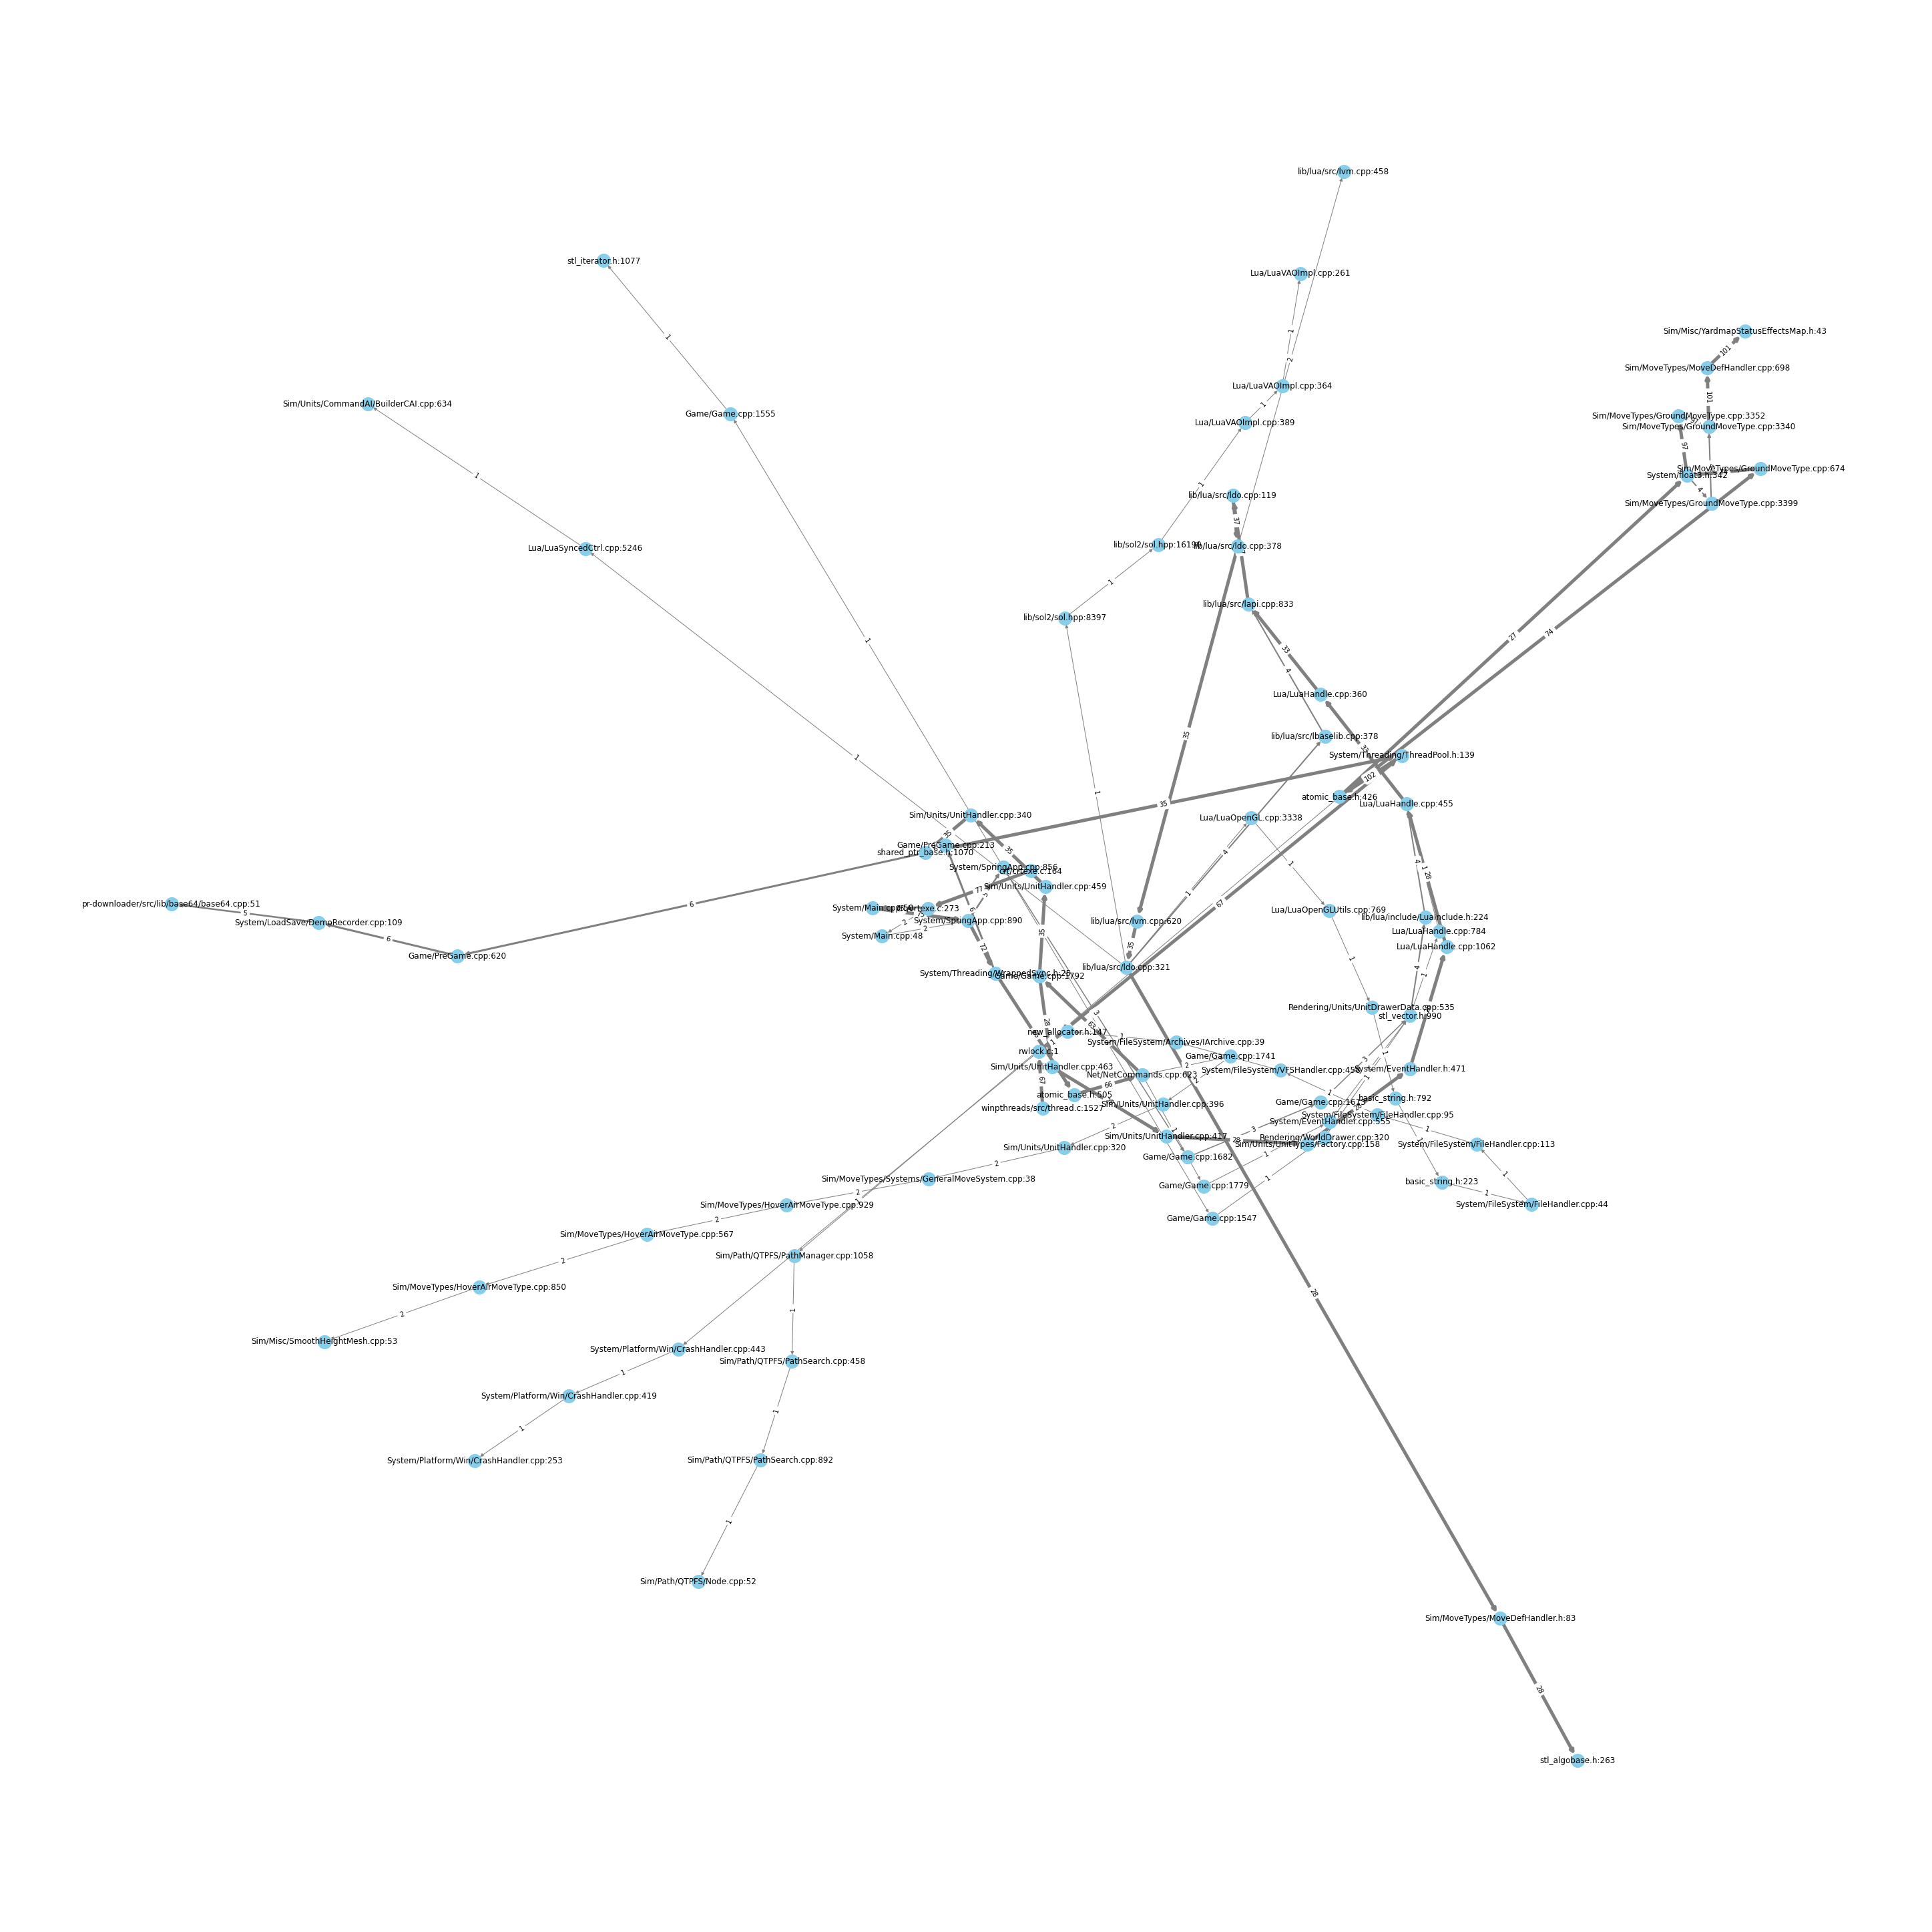

In [15]:
import random
import networkx as nx
import matplotlib.pyplot as plt

def create_graph(n_nodes, alpha = 0.5):
    G = nx.DiGraph()
    G.add_nodes_from(range(n_nodes))
    for i in range(n_nodes):
        for j in range(i+1,n_nodes):
            if random.random() < alpha:
                weight=random.randint(1,10)
                G.add_edge(i, j, weight=weight)
    return G
  
def create_log_graph(nodes, edges, alpha = 0.5):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for i,node in enumerate(nodes):
        G.add_node(node, size = 10000)
    for edgekey, edgeweight in edges.items():
        G.add_edge(nodes[edgekey[0]], nodes[edgekey[1]], weight = edgeweight)
    return G

def display_graph(G):
    pos = nx.spring_layout(G, weight=None)
    weight_labels = nx.get_edge_attributes(G, 'weight')

    fig = plt.figure(1, figsize=(40, 40), dpi=72)
    # Modify edge thickness based on weights
    edge_widths = [max(1, min(5, 0.5 * G[u][v]['weight'])) for u, v in G.edges()]
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=400, width=edge_widths)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weight_labels)

    plt.show()


n_nodes = 5
G = create_log_graph(nodelist, edgedict, alpha = 0.5)
display_graph(G)

In [13]:
print(len(results))

146
